In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL # pil is for python immaging library. it is used to process image in different format in python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


Download dataset

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin= dataset_url, untar = True)
data_dir = pathlib.Path(data_dir)

Exploring the data

In [ ]:
# getting the image count

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


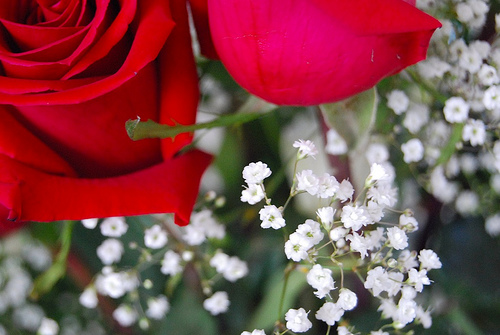

In [ ]:
# lets explore our first image

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

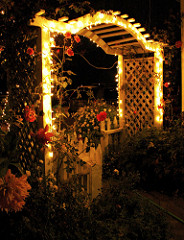

In [ ]:
PIL.Image.open(str(roses[1]))

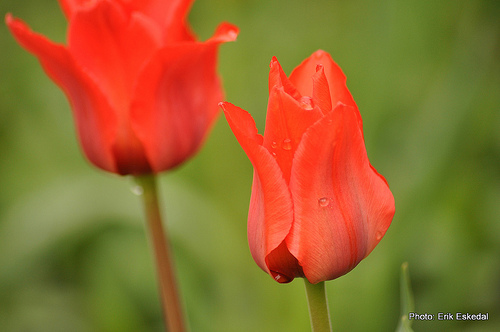

In [ ]:
#checking the tulips

tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [ ]:
#defining the batch size , height and width

batch_size = 32
img_height = 100
img_width = 100

Creating training and validation subset.

splitting the dataset into training and validation split in 80:20

In [ ]:
#spliting the train and validation

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split= 0.2,
    subset = "validation" ,
    seed = 123,
    image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Checking class names of flower

In [ ]:
#differnt classes of flower
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


visualize the data

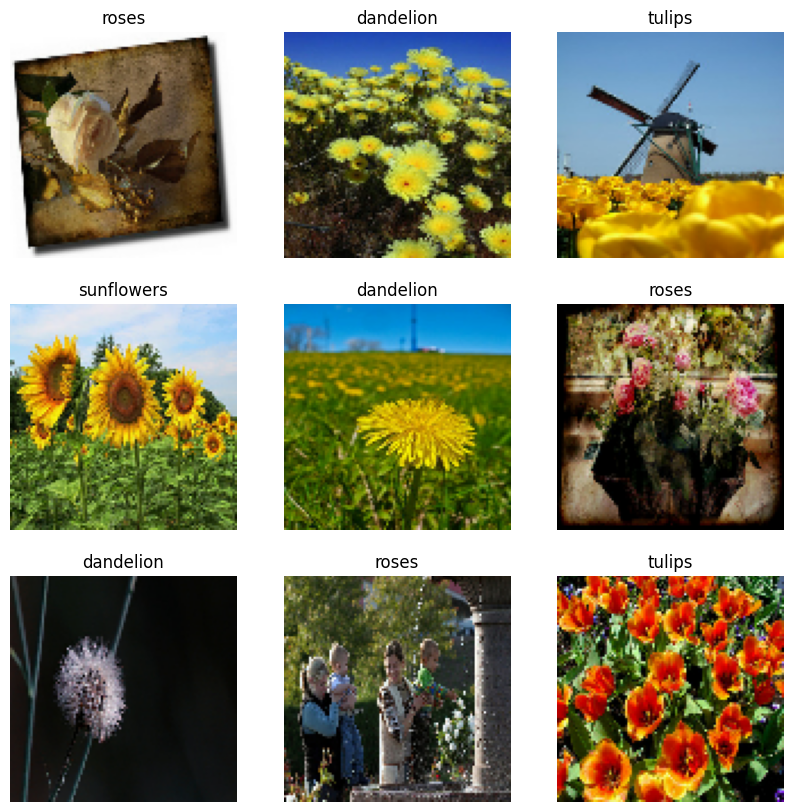

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()


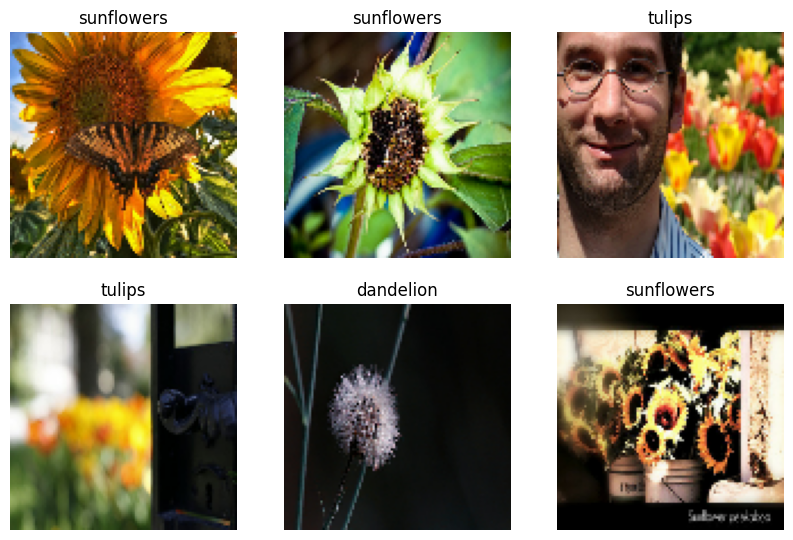

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

checking size of image_batch and labels_batch


image batch in tensor of shape (32,180,180,3). the batch 32 image of shape 180x180x30. the last dimension shows the colors channel RGB. the label_batch is a tensor of the shape(32,), corresponding labels to the 32 image

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break  # if break is not given then it will be a long loop printing the same values

(32, 100, 100, 3)
(32,)


Configuring dataset for performance

dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. this will ensure the dataset does not become a bottleneck while trinning model

In [ ]:
#configure dataset performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardization of the data.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# pixels value are in [0,1]
print(np.min(first_image), np.max(first_image))

0.0 1.0


Building the CNN

In [ ]:
from tensorflow.python.ops.gen_nn_ops import Conv2D
num_classes = 5
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height , img_width, 3)),
    layers.Conv2D(16,3, padding = 'same' , activation= 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = "same", activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = "same", activation = 'relu') ,
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
  ])



In [ ]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 25, 25, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 64)       

Training the model using the epochs

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,  # Corrected the typo in 'validation_data'
    epochs=epochs
)


Epoch 1/10
92/92 [==============================] - 30s 315ms/step - loss: 1.3763 - accuracy: 0.3869 - val_loss: 1.0966 - val_accuracy: 0.5654
Epoch 2/10
92/92 [==============================] - 29s 316ms/step - loss: 1.0663 - accuracy: 0.5691 - val_loss: 1.0705 - val_accuracy: 0.5518
Epoch 3/10
92/92 [==============================] - 27s 298ms/step - loss: 0.8936 - accuracy: 0.6471 - val_loss: 1.0204 - val_accuracy: 0.6076
Epoch 4/10
92/92 [==============================] - 30s 327ms/step - loss: 0.7886 - accuracy: 0.6958 - val_loss: 0.8924 - val_accuracy: 0.6499
Epoch 5/10
92/92 [==============================] - 29s 321ms/step - loss: 0.6503 - accuracy: 0.7510 - val_loss: 0.9006 - val_accuracy: 0.6635
Epoch 6/10
92/92 [==============================] - 30s 331ms/step - loss: 0.5195 - accuracy: 0.8069 - val_loss: 0.9177 - val_accuracy: 0.6594
Epoch 7/10
92/92 [==============================] - 29s 311ms/step - loss: 0.3982 - accuracy: 0.8597 - val_loss: 1.0758 - val_accuracy: 0.6662

Plotting the graph to comparision of training and validation accuracy

Text(0.5, 1.0, 'Training and validation Accuracy')

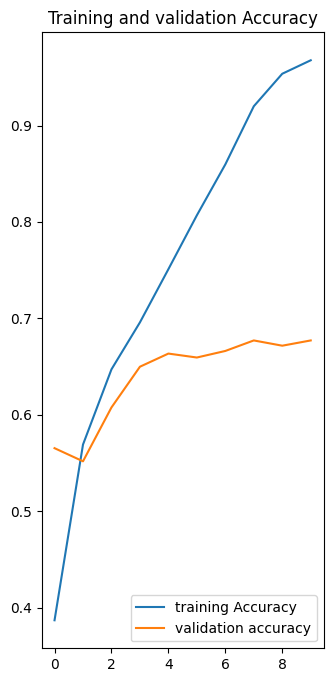

In [ ]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label = "training Accuracy")
plt.plot(epoch_range, val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

Conclusion
training accuracy is going around 98 % where as validation accuracy is not even touching 70%.
this shows that CNN model is overfitting and not performing well when we build complex model. lets see how this overfittinng problem can be solved using some another model such as RESNET